In [3]:
import re
import os.path
import fnmatch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import matplotlib.pyplot as plt
from scipy import signal, stats
from matplotlib.patches import Patch
from sklearn.decomposition import PCA

%matplotlib inline
warnings.filterwarnings('ignore')

In [4]:
#%% figure styling

sns.set(style='ticks', palette='colorblind')

# plt.rcParams['figure.figsize'] = (6,3)
# plt.rcParams['figure.dpi'] = 200

figure_folder = '../plots'
figure_prefix = 'behavior_clustering_test_2'

def figname(name):
    return os.path.join(figure_folder, '{}--{}'.format(figure_prefix, name))

In [14]:
#%% define functions

def get_kde_vals(arr, xvals=None):
    
    x = arr[~np.isnan(arr)]
    kde = stats.gaussian_kde(x, bw_method='scott')
    
    if xvals is None:
        xvals = np.linspace(np.min(x)-1, np.max(x)+1, num=150)
    yvals = kde.evaluate(xvals)
    
    return xvals, yvals

# get the angle names to analyze (use _BC instead of _abduct for now)
def get_angle_names(angles, angle_types):
    angle_names = np.array([])
    for ang in angle_types:
        angle_names = np.append(angle_names, [s for s in list(angles.columns) if '1' in s and ang in s])
    # angle_names = angle_names + ['fictrac_speed', 'fictrac_rot']
    return angle_names

# adjust _rot angles so there are no discontinuities
def adjust_rot_angles(angles, angle_names):
    rot_angs = [r for r in angle_names if '_rot' in r]
    for ang in rot_angs:
        r = np.array(angles[ang])
        r[r > 50] = r[r > 50] - 360
        angles[ang] = r
    return angles

# time based features
def time_features(data, angles, filenames, label_type, nperseg, noverlap):
    
    X_list = []
    labels_list = [] # remember to append to stft labels
    
    angle_types = np.array(['_BC', '_flex', '_rot'])
    angle_names = get_angle_names(angles, angle_types)
    
    for filename in filenames:
        sub_ixs = data['filename'] == filename
        # X_sub = data.loc[sub_ixs, bodyparts_xyz]
        X_sub = np.array(angles.loc[sub_ixs, angle_names])
        labels_sub = np.array(data.loc[sub_ixs, label_type])
    
        for i in range(0, X_sub.shape[0], noverlap):
            if X_sub.shape[0] >= i+nperseg:
                X_list.append(X_sub[i:i+nperseg].T)
                labels_list.append(labels_sub[i+nperseg//2])
    
    X_times = np.array(X_list)
    labels_times = np.array(labels_list)
    
    return X_times, labels_times

# stft based features
def stft_features(data, angles, filenames, label_type, fps, nperseg, noverlap):

    X_list = []
    labels_list = []
    
    angle_types = np.array(['_BC', '_flex', '_rot'])
    angle_names = get_angle_names(angles, angle_types)
    
    for filename in filenames:
        sub_ixs = data['filename'] == filename
        # X_sub = data.loc[sub_ixs, bodyparts_xyz]
        X_sub = angles.loc[sub_ixs, angle_names]
    
        freqs, times, Z = signal.stft(X_sub, fs=fps, nperseg=nperseg, noverlap=noverlap,
                                      axis=0, padded=False, boundary=None)
        Zs = np.log(np.abs(Z.swapaxes(0, 2)))
    
        labels_sub = np.array(data.loc[sub_ixs, label_type])
        labels_sub_down = labels_sub[::noverlap]
        Zs = Zs[:len(labels_sub_down)]
    
        # good = ~pd.isnull(labels_sub_down)
        good = np.arange(len(Zs))
    
        X_list.append(Zs[good])
        labels_list.append(labels_sub_down[good])
    
    X_stft = np.vstack(X_list)
    labels_stft = np.hstack(labels_list)
    
    return X_stft, labels_stft


# get labels according to feature chosen (filename, bout, fly, behavior, etc)
def get_label_dict(labels):
    
    labels_ids = np.zeros(labels.shape, dtype='int32')
    labels_ids[:] = -1 # default for unlabeled data
    
    bad = pd.isnull(labels) | (labels == 'nan')
    labels_types = np.unique(labels[~bad])
    label_dict = dict(zip(labels_types, range(len(labels_types))))
    
    for label, num in label_dict.items():
        labels_ids[label == labels] = num
        
    return label_dict, labels_types, labels_ids

In [15]:
prefix = r'/media/turritopsis/katie/behavior-classifier/grooming_only'
angles_path = os.path.join(prefix, 'angles_fictrac_labeled_grooming.csv')
pose3d_path = os.path.join(prefix, 'pose3d_fictrac_labeled_grooming.csv')
# behaviors = os.path.join(prefix, 'behavior_labels_merged_training.csv')

fps = 300.0 # I happen to know this for this dataset

data = pd.read_csv(pose3d_path, index_col = False)
angles = pd.read_csv(angles_path, index_col = False)
# behaviors = pd.read_csv(behaviors)

# get the joints to analyze
bodyparts = np.array(['L1A', 'L1B', 'L1C', 'L1D', 'L1E', 
                      'L2A', 'L2B', 'L2C', 'L2D', 'L2E', 
                      'L3A', 'L3B', 'L3C', 'L3D', 'L3E', 
                      'R1A', 'R1B', 'R1C', 'R1D', 'R1E', 
                      'R2A', 'R2B', 'R2C', 'R2D', 'R2E',
                      'R3A', 'R3B', 'R3C', 'R3D', 'R3E'])

bodyparts = [x.replace('_error', '') for x in data.columns if '_error' in x]
bodyparts_xyz = [bp + '_' + x for bp in bodyparts for x in ['x', 'y', 'z']]

angle_types = np.array(['_BC', '_flex', '_rot'])
angle_names = get_angle_names(angles, angle_types)
angles = adjust_rot_angles(angles, angle_names)

fly_ids = np.unique(data.flyid)

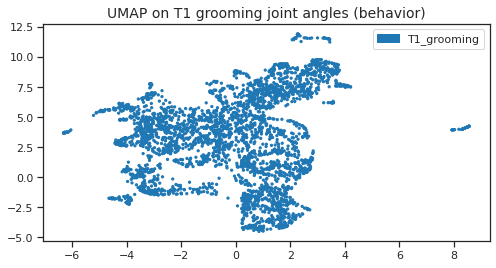

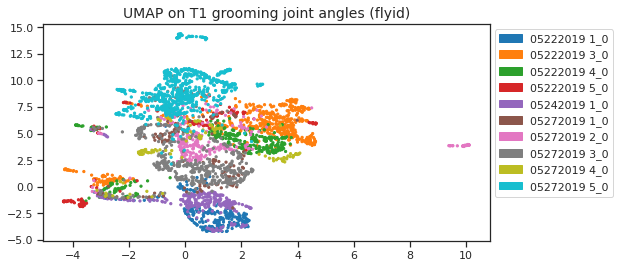

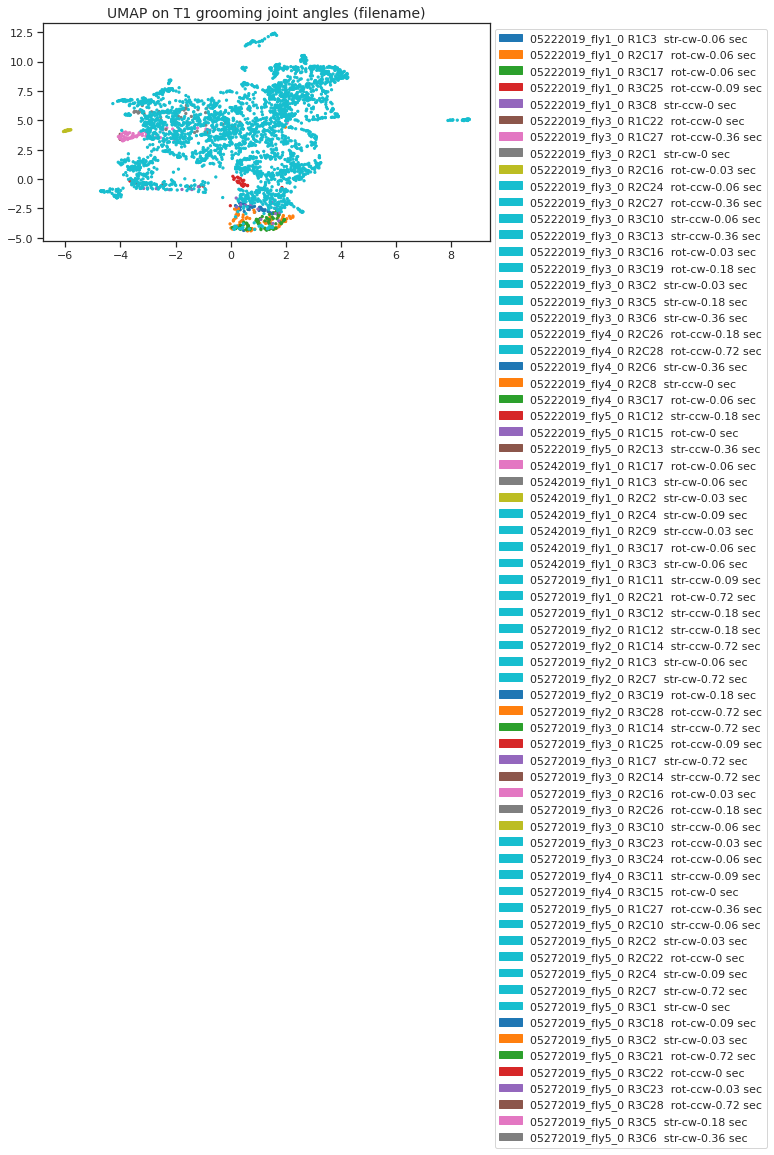

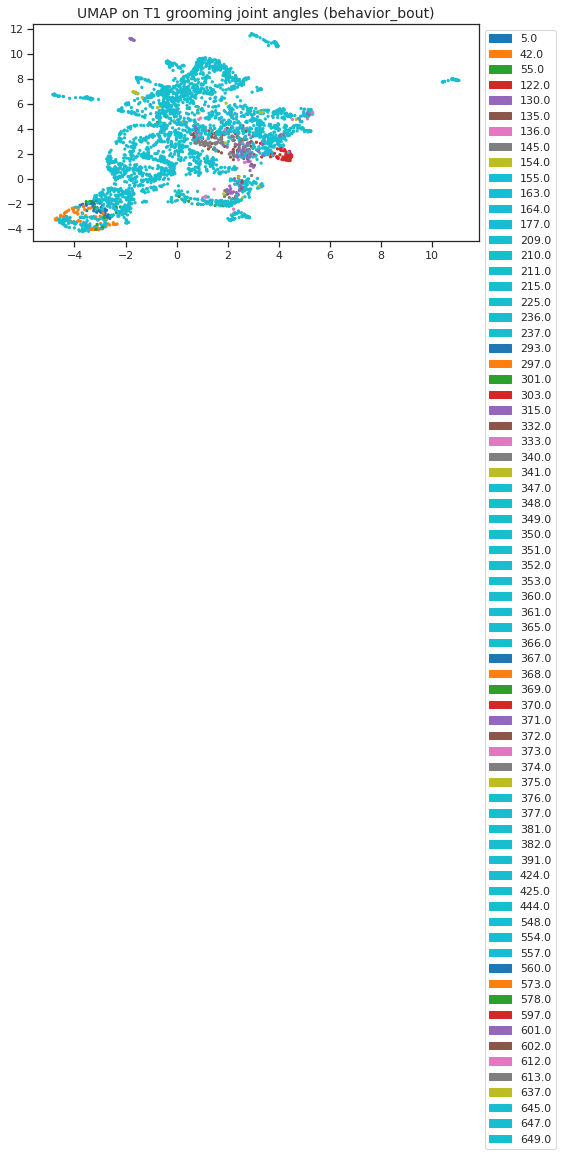

In [16]:
nperseg = 16
noverlap = int(nperseg // 2)
filenames = np.unique(data.loc[:, 'filename'])
# np.random.shuffle(filenames)
label_types = ['behavior', 'flyid', 'filename', 'behavior_bout']

cmap = plt.get_cmap('tab10')
# cmap = plt.get_cmap('Spectral')

for j in range(len(label_types)):

    # individual inputs for time and stft features
    X_stft, labels_stft = stft_features(data, angles, filenames, label_types[j], fps, nperseg, noverlap)
    X_times, labels_times = time_features(data, angles, filenames, label_types[j], nperseg, noverlap)
    
    # both time and stft features, but could use only the stft or time data/labels
    X = np.dstack([X_stft, X_times])
    X_in = X.reshape(X.shape[0], -1)
    labels = labels_stft
    label_dict, labels_types, labels_ids = get_label_dict(labels)
    
    # umap
    xmap = umap.UMAP(init='spectral', min_dist=0.2, n_components=2)
    X_map = xmap.fit_transform(X_in)
    
    fig = plt.figure(figsize = (10,5))
    good = labels_ids != -1
    # plt.scatter(X_map[good, 0], X_map[good, 1], c=labels_ids[good], cmap = cmap, s=5)
    plt.scatter(X_map[good, 0], X_map[good, 1], c=cmap(labels_ids[good]), s=5)
    plt.title('UMAP on T1 grooming joint angles (' + label_types[j] + ')', fontsize = 14)
    n = len(labels_types)-1
    patches = [Patch(color=cmap(i % 20), label=x) for i, x in enumerate(labels_types)]
    plt.legend(handles=patches, bbox_to_anchor = (1, 1))
    plt.show()

In [ ]:
fig = plt.figure(figsize = (10,5))
plt.scatter(X_map[:, 0], X_map[:, 1], color ='k', s=5)
plt.title('UMAP on T1 grooming joint angles', fontsize = 14)
plt.show()